In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from image_fact import ImageFact

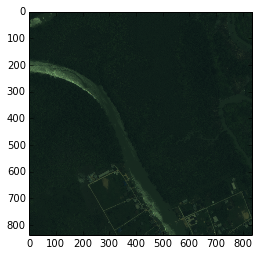

In [2]:
# Preview the training image

i = ImageFact('6070_2_3', ['7', '8'])
#i = ImageFact('6100_2_2', ['7', '8'])
#i = ImageFact('6110_4_0', ['7', '8'])

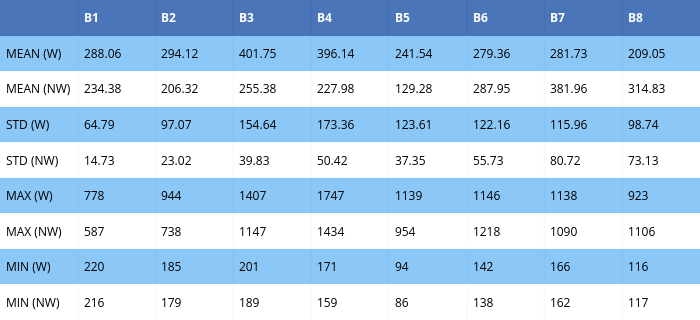

In [3]:
# Pixel stats on different bands in the multi spectral image

i.m_bands_stats()

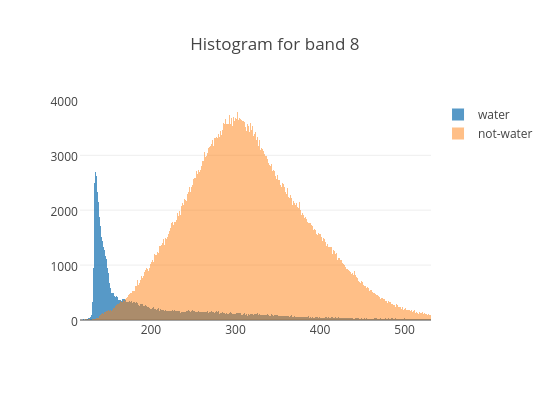

In [4]:
# Histogram plot on band 8 from the multi spectral image

i.plot_histogram_of_band_in_img_m(8)

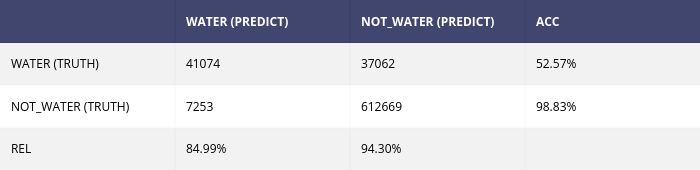

Average accuracy: 75.70%
Average reliability: 89.64%
Overall accuracy: 93.65%


(41074, 612669, 7253, 37062)

In [5]:
# Perform density slicing on band 8, with upper and lower bound set to 170 and 116

i.density_slicing(8, 116, 170)

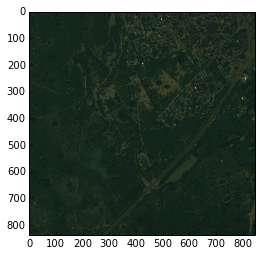

In [10]:
# Load test image 1

ti1 = ImageFact('6100_2_2', ['7', '8'])

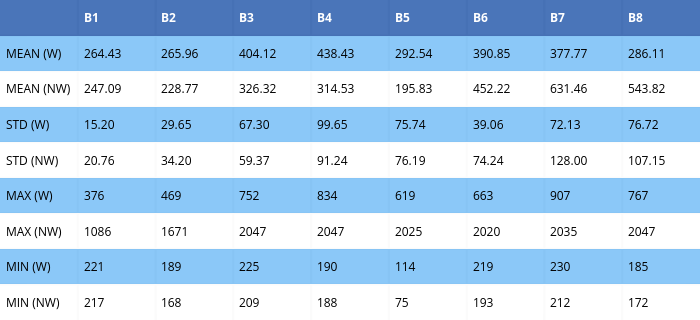

In [11]:
ti1.m_bands_stats()

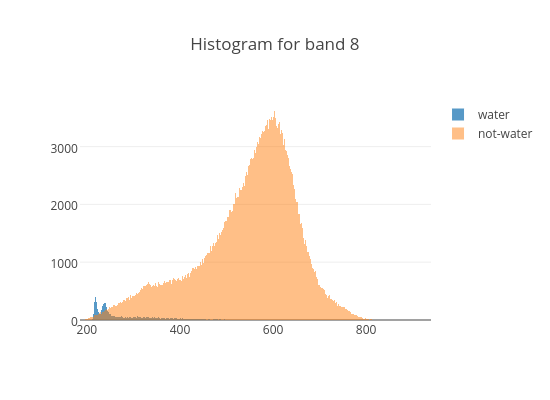

In [16]:
#ti1.density_slicing(8, 116, 170)
ti1.plot_histogram_of_band_in_img_m(8)

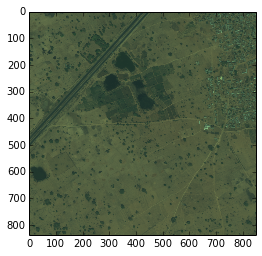

In [6]:
# Load test image 2

ti2 = ImageFact('6110_4_0', ['7', '8'])

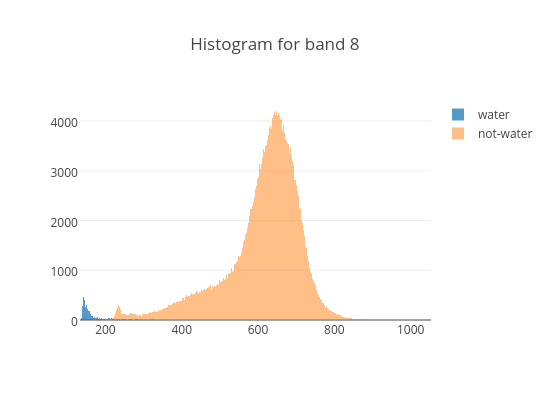

In [8]:
ti2.plot_histogram_of_band_in_img_m(8)

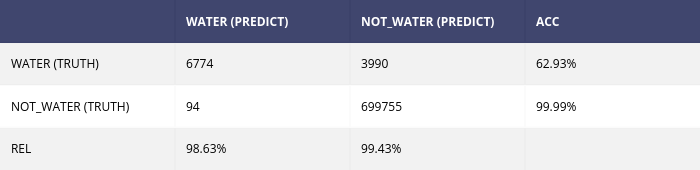

Average accuracy: 81.46%
Average reliability: 99.03%
Overall accuracy: 99.43%


(6774, 699755, 94, 3990)

In [7]:
ti2.density_slicing(8, 116, 170)

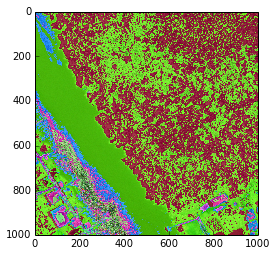

In [16]:
plt.imshow(i.img_rgb[2000:3000, 1500:2500, :])

<matplotlib.colorbar.Colorbar instance at 0x7f542b7e3758>

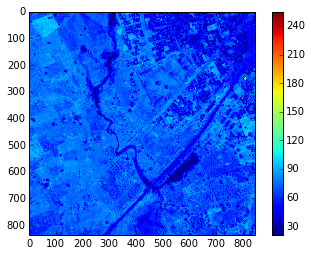

In [257]:
plt.imshow(cv2.convertScaleAbs(i.img_m[:, :, 7], alpha=(255.0/2048.0)))
plt.colorbar()